# Rotational Correction

A problem in the current code is that it relies on perfect symmetry. This can be correct using an edge detector and mapping from one slice to the next. This assumes that the angle is very small and so the difference between each edge is negligable.

In [1]:
#Imports libraries
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("TkAgg")
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
import numpy as np
from scipy import ndimage as ndi
from skimage import io,feature
import skimage.transform as skt
from tkinter import *

Next an image is loaded to test the edge correction facilities. The image has already been flat field corrected.

In [2]:
#Reads in image`
image = io.imread('Processed_images/20kV198uA_contrast.tif')

#### Edge detection

For now two slices will be taken from the image to experiment with edge detection.

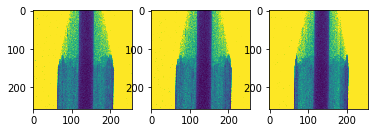

In [3]:
#Read in slices
slice1 = image[0,:,:]
slice2 = image[1,:,:]
slice10 = image[9,:,:]

#Displays the slices
_,ax = plt.subplots(1,3)
ax[0].imshow(slice1)
ax[1].imshow(slice2)
ax[2].imshow(slice10)

plt.show()

Applying edge detection with varying threshold levels. For now the canny edge detector will be used from cv2.

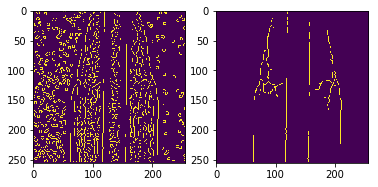

In [4]:
#Detects edges
sigma = 2
edges1 = feature.canny(slice1,sigma=sigma,low_threshold=100,high_threshold=110)
edges2 = feature.canny(slice2,sigma=sigma)

#Displays resuls
_,ax = plt.subplots(1,2)
ax[0].imshow(edges1)
ax[1].imshow(edges2)
plt.show()

#### Translational Correction

Next, a translational correction algorithm will be used on two slices comparing edge detection with no edge detection.

In [5]:
#Moves the second image so it is inline with the first image.
def lateral_correction1(img1,img2):
    
    #Defines initial variables
    trans_range = 20
    diff_ary = np.zeros(2*trans_range + 1)
    
    #Means the images to reduce noise interference
    
    #Compares img2 with img1 with different tranlations
    for i in range(-trans_range,trans_range,1):
        
        img_roll = np.roll(img2, i)
        diff_ary[i] = np.mean(np.abs(img1 - img_roll))
        
    diff_index = np.argmin(diff_ary) - trans_range
        
    return diff_index
    
  

In [6]:
lateral_correction1(slice1,slice10)

0

Now exploring the capabilites of rotational correction.

In [7]:
def rotational_correction(img1,img2):
    
    #Defines initial variables
    rot_range = 2
    dtheta = 0.1
    rot_ary = np.arange(-rot_range,rot_range,dtheta)
    diff_ary = np.zeros(len(rot_ary))
    
    #Filters the images
    flt_size = 5
    img1 = ndi.filters.median_filter(img1,size=flt_size)
    img2 = ndi.filters.median_filter(img2,size=flt_size)
    
    #Cycles through rotations
    for i in range(0,len(rot_ary)):
        
        #Rotates image
        img_rot = ndi.rotate(img2,rot_ary[i],reshape=False)
        diff_ary[i] = np.mean(np.abs(img1-img_rot))
        
    #Returns angle of minimum difference
    rot_angle = rot_ary[np.argmin(diff_ary)]
    plt.imshow(ndi.rotate(img2,rot_angle,reshape=False))
    
    return rot_angle

1.7763568394002505e-15

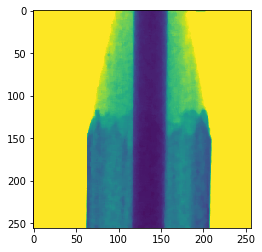

In [8]:
rotational_correction(slice1,slice2)

Next the two functions are combined to give a single slice correction function.

In [9]:
def orientation_correction(img1,img2):
    
    #Defines initial variables
    rot_range = 1
    dtheta = 0.1
    rot_ary = np.arange(-rot_range,rot_range+dtheta,dtheta)
    
    trans_range = 1
    trans_ary = np.arange(-trans_range,trans_range,1)
    
    diff_ary = np.zeros((len(rot_ary),len(trans_ary)))

    #Filters image
    flt_size = 1
    img1 = ndi.filters.median_filter(img1,size=flt_size)
    img2 = ndi.filters.median_filter(img2,size=flt_size)

    #Converts images to same type
    im_type = 'float32'
    img1 = img1.astype(im_type)
    img2 = img2.astype(im_type)
    
    for i in range(0,len(trans_ary)):
        
        #Translates the image
        img_trans = np.roll(img2,trans_ary[i])
        for j in range(0,len(rot_ary)):
        
            #Rotates image
            img_rot = ndi.rotate(img_trans,rot_ary[j],reshape=False)
            diff_ary[j][i] = np.mean(np.abs(img1-img_rot))

        
    #Returns translation and angle of minimum difference
    coords = np.unravel_index(np.argmin(diff_ary),diff_ary.shape)
    plt.plot(diff_ary)

    return trans_ary[coords[1]],rot_ary[coords[0]]

(0, -2.220446049250313e-16)

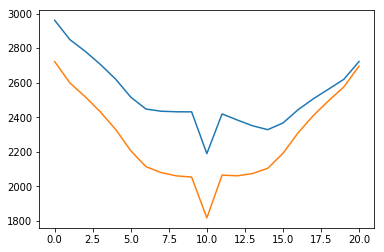

In [10]:
orientation_correction(image[0,:,:],image[1,:,:])

The function seems to always return no rotation or translation.

# Improved reconstruction method

Currently, the program opperates through some primative rotation techniques. In this section I will explore the use of more advanced libraries to perform the task more accurately.

(360, 256, 256)


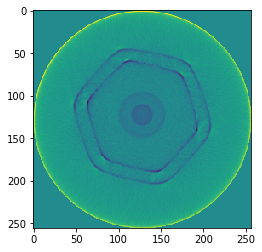

In [11]:
#Converts the image to a sinogram
angles = np.arange(0,360,1)
print(image.shape)
reconstruction = skt.iradon(ndi.rotate(image[:,200,:],90),theta=angles,circle=True)
plt.imshow(reconstruction);plt.show()

This seems to have solved the whole 3D reconstruction problem.

# Embedding image in Tkinter window

Initialises window.

In [12]:
#Initialises the window (GUI)
window = Tk()
window.title("Filtered Back Projection")

''

Adds the image

In [13]:
fig = Figure(figsize=(6,6))
a = fig.add_subplot(111)
a.imshow(image[255,:,:])

canvas = FigureCanvasTkAgg(fig, master=window)
canvas.get_tk_widget().grid(row=60,column=0)
canvas.draw()

def slider_moved(val):
    a.clear()
    a.imshow(image[int(val),:,:])
    canvas.draw()

Adds the slider.

In [14]:
#Creates slider for slice selection
slider = Scale(window, from_=0, to=255, orient=HORIZONTAL,command=slider_moved)
slider.grid(row=0,column=0)
window.update()

In [15]:
window.mainloop()

## Sinogram Correction

The problem persists with the wobble and the image not being centred. The plan is to solve this on a sinogram level by taking each column of the sinogram and ensuring it is symetrical. This can be done by loading half of the pixels and subtracting the second half from it. If the column is symetrical the result would be 0. Hence the minimum value of this operation yields the most symetrical result.`

####  Obtaining the sinogram

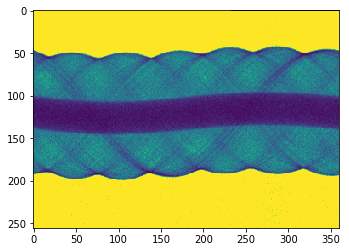

In [16]:
sinogram = ndi.rotate(image[:,200,:],90)
plt.imshow(sinogram);plt.show()

#### Finding the point of symetry

In [40]:
def sym_line(line):
    
    #Defines initial variables
    roll_range = 20
    
    #Gets midpoint of line
    L = len(line)
    mp = int(L/2)
    
    #Creates comparison array
    diff_ary = np.zeros(2*roll_range+1)
    
    for i in range(0,len(diff_ary)):
        
        #Duplicates line to preserve original line
        test = np.roll(line,i-roll_range)
        
        #Finds differance
        diff_ary[i] = np.mean(np.abs(np.flip(test[0:mp]) - test[mp:L]))
        
    #Finds minimum difference
    roll_val = np.argmin(diff_ary) - roll_range
    
    return roll_val
        
        
        
        

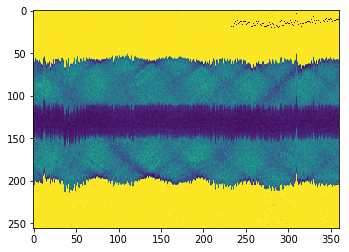

In [18]:
correct_sino = np.zeros((256,360))
for i in range(0,360):
    
    correct_sino[:,i] = np.roll(sinogram[:,i],sym_line(sinogram[:,i]))
    
plt.imshow(correct_sino)

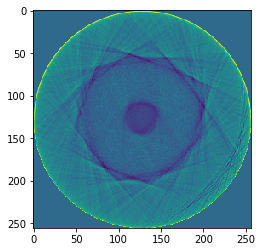

In [23]:
raw_irad =skt.iradon(correct_sino,circle=True)
plt.imshow(raw_irad)

As seen from the above image this seems to solve the main problem however the algorithm needs to be refined to avoid loss of quality. The next stage is to investigate improvements. 

#### Filtering to reduce noise

In [38]:
#Creates sinogram with filtered results
c_sino_flt = np.zeros((256,360))
flt_sino = ndi.filters.gaussian_filter1d(sinogram,1,axis=0)
for i in range(0,360):
    
    c_sino_flt[:,i] = np.roll(sinogram[:,i],sym_line(flt_sino[:,i]))
    
flt_irad = skt.iradon(c_sino_flt,circle=True)

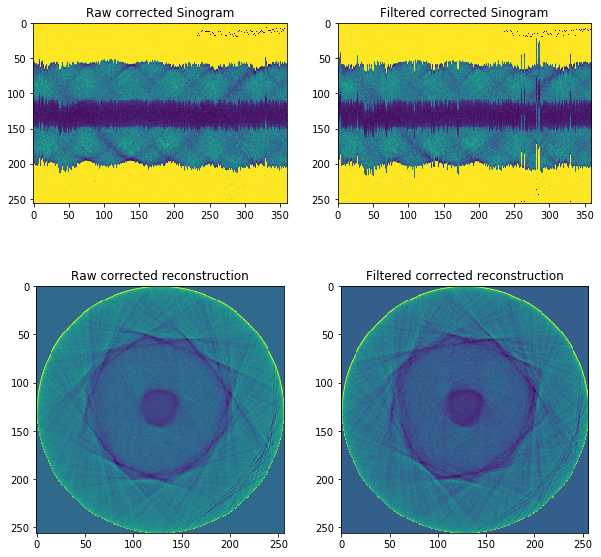

In [180]:
#Changes figure size parameters
matplotlib.rcParams['figure.figsize'] = [10, 10]

#Compares sinograms and projections
ax = plt.subplot(221)
ax.imshow(correct_sino)
ax.set_title('Raw corrected Sinogram')
ax = plt.subplot(222)
ax.imshow(c_sino_flt)
ax.set_title('Filtered corrected Sinogram')
ax = plt.subplot(223)
ax.imshow(raw_irad)
ax.set_title('Raw corrected reconstruction')
ax = plt.subplot(224)
ax.imshow(flt_irad)
ax.set_title('Filtered corrected reconstruction')
plt.show()

Unsure about axis types but experimenting with both and various filter values the filtered images seems to be worse. This is probably due to the image already having minimal noise due to the flat field correction and contrast.

#### Altering search regions

In [148]:
#Redefining line code to display search region for variable parameters
def sym_line(line,roll_range,match_range):
    
    #Gets midpoint of line
    L = len(line)
    mp = int(L/2)
    
    #Creates comparison array
    diff_ary = np.zeros(2*roll_range+1)
    
    for i in range(0,len(diff_ary)):
        
        #Duplicates line to preserve original line
        test = np.roll(line,i-roll_range)
        
        #Finds differance
        diff_ary[i] = np.mean(np.abs(np.flip(test[mp-match_range:mp+1]) - test[mp:mp+match_range+1]))
        
    #Finds minimum difference
    roll_val = np.argmin(diff_ary) - roll_range
    
    return roll_val

def sym_line_wreg(sinogram,roll_range,match_range):
    
    #Creates the return array for the sinogram
    rtn_sino = np.zeros((256,360))
    
    #Defines midpoint
    mp = 128
    
    #Corrects the image
    for i in range(0,360):
        
        rtn_sino[:,i] = np.roll(sinogram[:,i],sym_line(sinogram[:,i],roll_range,match_range))
        rtn_sino[mp-match_range,i] = 0
        rtn_sino[mp,i] = 0
        rtn_sino[mp+1,i] = 0
        rtn_sino[mp+match_range + 1,i] = 0
        
    return rtn_sino

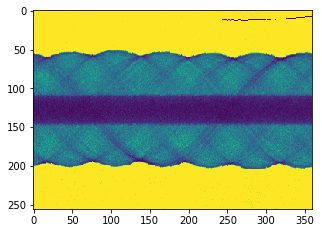

In [182]:
matplotlib.rcParams['figure.figsize'] = [5, 5]
sino_wreg = sym_line_wreg(sinogram, 25, 25,3)
plt.imshow(sino_wreg)

If the object had a dark center then the probablem can made easier by thresholding the image to only include the dark centre. Hence the problem is as simple as centering a line with no noise. This is a reasonable assumption to make as the reconstructed object will have a dense core (such as a pen or pencil).

#### Sinogram to binary core

In [183]:
#Binary core image
def binary_core(sinogram,threshold,radius):
    
    bin_sino = np.zeros((256,360))
    bin_sino[sinogram < threshold] = 1
    bin_sino = ndi.filters.median_filter(bin_sino,5)
    
    return bin_sino

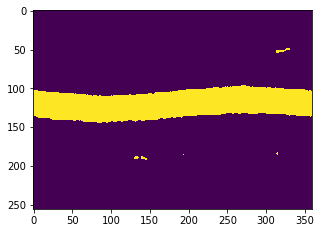

In [184]:
plt.imshow(binary_core(sinogram,10000,3))

This is essentially a fancy threshold function with a median filter. Next to apply it to the current problem

Testing the alignment of the thresholded image.

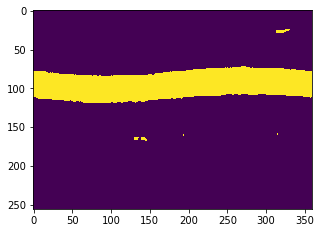

In [186]:
sino_binary = sym_line_wreg(binary_core(sinogram,10000,3), 25, 25,3)
plt.imshow(sino_binary)

In [187]:
def sym_line_wreg(sinogram,roll_range,match_range,radius):
    
    #Creates the return array for the sinogram
    rtn_sino = np.zeros((256,360))
    
    #Defines midpoint
    mp = 128
    
    #Gets thresholded images
    thresh_sino = binary_core(sinogram,10000,radius)
    
    #Corrects the image
    for i in range(0,360):
        
        rtn_sino[:,i] = np.roll(sinogram[:,i],sym_line(thresh_sino[:,i],roll_range,match_range))
        
    return rtn_sino

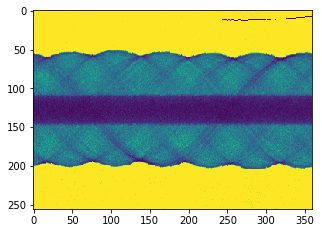

In [188]:
true_sino = sym_line_wreg(sinogram,25,25,3)
plt.imshow(true_sino)

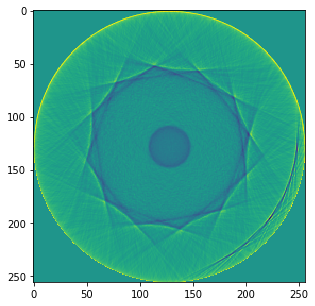

In [189]:
true_irad = skt.iradon(true_sino,circle=True)
plt.imshow(true_irad)

The result seem to be a success for the core but the outside of the images have still lost quality. Maybe now appying a small filter to the image would help improve the situation.

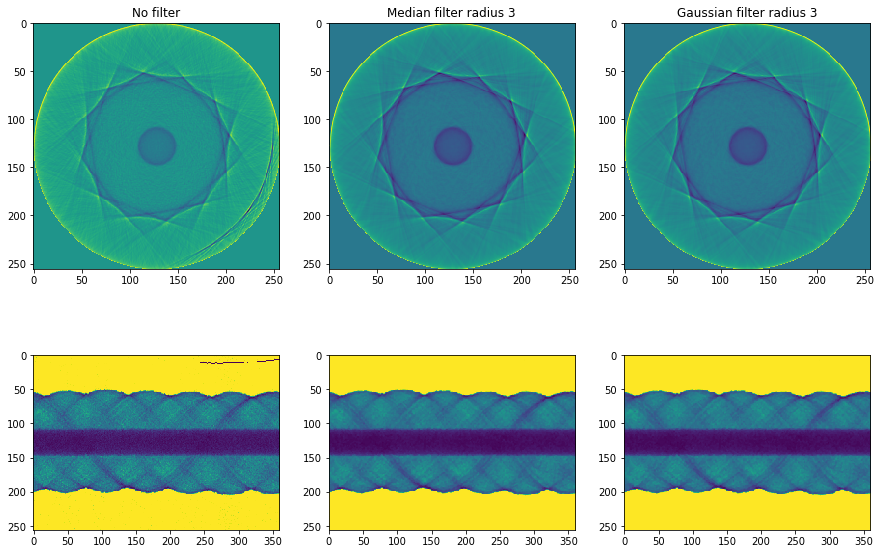

In [199]:
#Median filters the sinogram
true_sino_flt_m = ndi.filters.median_filter(true_sino,3)
true_irad_flt_m = skt.iradon(true_sino_flt_m,circle=True)

#Gaussian filters the sinogram
true_sino_flt_g = ndi.filters.median_filter(true_sino,3)
true_irad_flt_g = skt.iradon(true_sino_flt_g,circle=True)

#Adjusts plotting parameters
matplotlib.rcParams['figure.figsize'] = [15, 10]

#Plots comparison image
ax = plt.subplot(231)
ax.imshow(true_irad)
ax.set_title('No filter')
ax = plt.subplot(234)
ax.imshow(true_sino)
ax = plt.subplot(232)
ax.imshow(true_irad_flt_m)
ax.set_title('Median filter radius 3')
ax = plt.subplot(235)
ax.imshow(true_sino_flt_m)
ax = plt.subplot(233)
ax.imshow(true_irad_flt_g)
ax.set_title('Gaussian filter radius 3')
ax = plt.subplot(236)
ax.imshow(true_sino_flt_g)
plt.show()

Comparison of the raw, median filtered and gaussian filtered sinograms with the reconstructed image displayed above.

## Image mapping alignment

There may already be ImageJ libraries for this but the first is essential for both. In order to successfully align a stack there needs to be a model template that fits the reconstruction. This could be manually solved by ImageJ and then using the template matching.